# Tensorflow Poison Frogs MNIST demo for Securing AI Lab deployment

This is an advanced version of the MNIST Poison Frogs Demo.
Here, users may parse through regular and poisoned images to select the best target parameters for attacks. 

## Setup

**Note:** This demo is specifically for the NCCoE DGX Workstation with hostname `dgx-station-2`.

Port forwarding is required in order to run this demo.
The recommended port mapping is as follows:

- Map `localhost:30080` on laptop to `localhost:30080` on `dgx-station-2`
- Map `localhost:35000` on laptop to `localhost:35000` on `dgx-station-2`

A sample SSH config file that enables the above port forwarding is provided below,

> ⚠️ **Edits required**: replace `username` with your assigned username _on the NCCoE virtual machines_!

```conf
# vm hostname: jumphost001
Host nccoe-jumphost001
    Hostname 10.33.53.98
    User username
    Port 54131
    IdentityFile %d/.ssh/nccoe-vm

# vm hostname: dgx-station-2
Host nccoe-k8s-gpu002
    Hostname 192.168.1.28
    User username
    Port 22
    IdentityFile %d/.ssh/nccoe-vm
    ProxyJump nccoe-jumphost001
    LocalForward 30080 localhost:30080
    LocalForward 35000 localhost:35000
```

Now, connect to the NCCoE VPN and SSH into the DGX Workstation,

```bash
ssh nccoe-k8s-gpu002
```

Next, we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

In [1]:
# Import packages from the Python standard library
import os
import pprint
import time
import warnings
from pathlib import Path
from typing import Tuple
import tarfile

# Please enter your username here.
USERNAME = "howard"

# Filter out warning messages
warnings.filterwarnings("ignore")

# Default address for accessing the RESTful API service
RESTAPI_ADDRESS = "http://localhost:30080"

# Base API address
RESTAPI_API_BASE = f"{RESTAPI_ADDRESS}/api"

# Default address for accessing the MLFlow Tracking server
MLFLOW_TRACKING_URI = "http://localhost:35000"

# Path to workflows archive
WORKFLOWS_TAR_GZ = Path("workflows.tar.gz")

# Experiment name (note the username_ prefix convention)
EXPERIMENT_NAME = f"{USERNAME}_mnist_poison_frogs"

# Set MLFLOW_TRACKING_URI variable, used to connect to MLFlow Tracking service
if os.getenv("MLFLOW_TRACKING_URI") is None:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI

# Import third-party Python packages
import numpy as np
import requests
from mlflow.tracking import MlflowClient

# Import utils.py file
import utils

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

Check that the Makefile works in your environment by executing the `bash` code block below,

In [2]:
%%bash

# Running this will just list the available rules defined in the demo's Makefile.
make

Available rules:

clean               Remove temporary files 
data                Download and prepare MNIST dataset 
initdb              Initialize the RESTful API database 
services            Launch the Minio S3 and MLFlow Tracking services 
teardown            Destroy service containers 
workflows           Create workflows tarball 


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Submit and run jobs

The jobs that we will be running are implemented in the Python source files under `src/`, which will be executed using the entrypoints defined in the `MLproject` file.
To get this information into the architecture, we need to package those files up into an archive and upload it to the lab API.
For convenience, the `Makefile` provides a rule for creating the archive file, just run `make workflows`,

In [3]:
%%bash

# Create the workflows.tar.gz file
make workflows

make: Nothing to be done for 'workflows'.


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To connect with the endpoint, we will use a client class defined in the `utils.py` file that is able to connect with the lab's RESTful API using the HTTP protocol.
We connect using the client below,

In [4]:
restapi_client = utils.SecuringAIClient(address=RESTAPI_API_BASE)

/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We need to register an experiment under which to collect our job runs.
The code below checks if the relevant experiment named `howard_mnist_poison_frogs` exists.
If it does, then it just returns info about the experiment, if it doesn't, it then registers the new experiment.

In [5]:
response_experiment = restapi_client.get_experiment_by_name(name=EXPERIMENT_NAME)

if response_experiment is None or "Not Found" in response_experiment.get("message", []):
    response_experiment = restapi_client.register_experiment(name=EXPERIMENT_NAME)

response_experiment

{'experimentId': 9,
 'lastModified': '2020-11-05T07:06:19.144936',
 'createdOn': '2020-11-05T07:06:19.144936',
 'name': 'howard_mnist_poison_frogs'}

Next, we need to train our model.
We will be using the V100 GPUs that are available on the DGX Workstation, which we can use by submitting our job to the `"tensorflow_gpu"` queue.
We will train three models, a shallow network model, a LeNet-5 model, and an AlexNet model,

In [6]:
def mlflow_run_id_is_not_known(response_fgm):
    return response_fgm["mlflowRunId"] is None and response_fgm["status"] not in [
        "failed",
        "finished",
    ]

response_le_net_train = restapi_client.submit_job(
    workflows_file=WORKFLOWS_TAR_GZ,
    experiment_name=EXPERIMENT_NAME,
    entry_point="train",
    entry_point_kwargs=" ".join([
        "-P batch_size=256",
        "-P register_model=True",
        "-P model_architecture=le_net",
        "-P epochs=30",
        "-P data_dir_train=/nfs/data/Mnist/training",
        "-P data_dir_test=/nfs/data/Mnist/testing",
    ]),
    queue="tensorflow_gpu",
    timeout="1h",
    
)

print("Training job for LeNet-5 neural network submitted")
print("")
pprint.pprint(response_le_net_train)

while mlflow_run_id_is_not_known(response_le_net_train):
    time.sleep(1)
    response_le_net_train = restapi_client.get_job_by_id(
        response_le_net_train["jobId"]
    )

Training job for LeNet-5 neural network submitted

{'createdOn': '2020-12-10T08:50:05.193374',
 'dependsOn': None,
 'entryPoint': 'train',
 'entryPointKwargs': '-P batch_size=256 -P register_model=True -P '
                     'model_architecture=le_net -P epochs=30 -P '
                     'data_dir_train=/nfs/data/Mnist/training -P '
                     'data_dir_test=/nfs/data/Mnist/testing',
 'experimentId': 9,
 'jobId': '8f039caf-2522-4264-9845-9565b31c8737',
 'lastModified': '2020-12-10T08:50:05.193374',
 'mlflowRunId': None,
 'queueId': 2,
 'status': 'queued',
 'timeout': '1h',
 'workflowUri': 's3://workflow/1a176f7f7c74448fbc0f473c2be2f912/workflows.tar.gz'}


# Poison Frogs: Image Selection
### Now we will examine the test set and select a particular image we'd like to corrupt:

Once the trained model is availabe from the previous run, lets run through the model to see how it behaves.

In [7]:
# Model download:
import requests
import os
import tensorflow as tf

def load_model_from_job_run(run_id, model_dir):
    params = {"path":"model/data/model.h5", "run_uuid": run_id}
    r = requests.get('http://localhost:35000/get-artifact', params=params)
    print("Accessing MLflow Client Server. Downloading model files.")
    print(r.headers)
    model_path = os.path.join(model_dir, 'model.h5')
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    with open(model_path, "wb+") as f:
        f.write(r.content)
    
    return tf.keras.models.load_model(model_path)

def load_images_from_job_run(run_id, image_dir):
    params = {"path":"adversarial_poison.tar.gz", "run_uuid": run_id}
    r = requests.get('http://localhost:35000/get-artifact', params=params)
    print("Accessing MLflow Client Server. Downloading image files.")
    print(r.headers)
    zip_path = os.path.join(image_dir, 'adversarial_poison.tar.gz')
    
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        
    with open(zip_path, "wb+") as f:
        f.write(r.content)
    
    with tarfile.open(zip_path, "r:gz") as f:
        f.extractall(path=image_dir)
    

while response_le_net_train['status'] != "finished":
    time.sleep(1)
    response_le_net_train = restapi_client.get_job_by_id(
        response_le_net_train["jobId"]
    )    
    
original_model = load_model_from_job_run(response_le_net_train['mlflowRunId'], './original_model')

Accessing MLflow Client Server. Downloading model files.
{'Server': 'nginx/1.18.0 (Ubuntu)', 'Date': 'Thu, 10 Dec 2020 08:56:12 GMT', 'Content-Type': 'application/octet-stream', 'Content-Length': '14446376', 'Connection': 'keep-alive', 'Content-Disposition': 'attachment; filename=model.h5', 'Last-Modified': 'Thu, 10 Dec 2020 08:56:12 GMT', 'Cache-Control': 'public, max-age=43200', 'Expires': 'Thu, 10 Dec 2020 20:56:12 GMT', 'ETag': '"1607590572.2842283-14446376-4154133791"'}


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):
/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:348: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


In [8]:
from os import listdir
from os.path import isfile, join
import random

image_list = []
for path, subdirs, files in os.walk("/nfs/1/datasets/Mnist/testing"):
    for name in files:
        image_list.append(os.path.join(path, name))


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Here we will randomly parse through images of interest and select a target image for attack.

The code below will pull an image from the MNIST test set, and run it through the trained mode.

For this demo, we'd like to start with an image that the model predicts correctly.

Rerun the the cell below until an image of interest is selected. Then proceed to the rest of the demo.

/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Image label: 6
Predicted label: 6
Filename: 00156.png


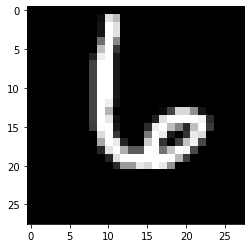

In [9]:
random_file = random.choice(image_list)
(label,filename) = random_file.split('/')[-2:]
#label = 9
#random_file = "/nfs/1/datasets/Mnist/testing/9/01045.png"
# load and show an image with Pillow
from PIL import Image
import tensorflow as tf
# Open the image form working directory
image = Image.open(random_file)
# summarize some details about the image
print("Image label: " + str(label) )
print("Predicted label: " + str(np.argmax(original_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))
print("Filename: " + filename)
# show the image
image = np.asarray(image)

# display the array of pixels as an image
import matplotlib.pyplot as plt
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [10]:
# Set target image to propogate into clean label images from another class
target_file = filename #"01045.png" #"07996.png" #filename
original_label = label #9 #5 #label

# Set target label here, this will be the new label that the target image will be reclassified as.
# If the target label matches original label, a new random label will be selected.
target_label = 6
while(target_label == int(label)):
    target_label = np.random.randint(0,10)
print(f"Current target label: {target_label}")

Current target label: 4


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Generating and Deploying Poisoned Images.

Now we will create our set of poisoned images and examine them visually.

Start by submitting the poison generation job below.

In [11]:
## Create poisoned images.
response_gen_poison_le_net = restapi_client.submit_job(
    workflows_file=WORKFLOWS_TAR_GZ,
    experiment_name=EXPERIMENT_NAME,
    entry_point="gen_poison",
    entry_point_kwargs=" ".join(
        [
            f"-P model={EXPERIMENT_NAME}_le_net/1",
            "-P model_architecture=le_net",
            "-P data_dir=/nfs/data/Mnist/training",
            f"-P target_image_path=/nfs/data/Mnist/testing/{original_label}/{target_file}",
            f"-P target_class={target_label}",
            "-P feature_layer_index=-1",
            "-P max_iter=100",
            "-P similarity_coeff=512",
            "-P watermark=0.30", #.30",
            "-P batch_size=100",
            "-P num_poisoned_batches=5"
            
        ]
    ),
    queue="tensorflow_gpu",
    depends_on=response_le_net_train["jobId"],
)

print("Poison attack (LeNet-5 architecture) job submitted")
print("")
pprint.pprint(response_gen_poison_le_net)
print("")

while mlflow_run_id_is_not_known(response_gen_poison_le_net):
    time.sleep(1)
    response_gen_poison_le_net = restapi_client.get_job_by_id(response_gen_poison_le_net["jobId"])

Poison attack (LeNet-5 architecture) job submitted

{'createdOn': '2020-12-10T08:56:14.642448',
 'dependsOn': '8f039caf-2522-4264-9845-9565b31c8737',
 'entryPoint': 'gen_poison',
 'entryPointKwargs': '-P model=howard_mnist_poison_frogs_le_net/1 -P '
                     'model_architecture=le_net -P '
                     'data_dir=/nfs/data/Mnist/training -P '
                     'target_image_path=/nfs/data/Mnist/testing/6/00156.png -P '
                     'target_class=4 -P feature_layer_index=-1 -P max_iter=100 '
                     '-P similarity_coeff=512 -P watermark=0.30 -P '
                     'batch_size=100 -P num_poisoned_batches=5',
 'experimentId': 9,
 'jobId': 'ef02ff4a-6e9f-44f0-a33e-7779bb0bfc56',
 'lastModified': '2020-12-10T08:56:14.642448',
 'mlflowRunId': None,
 'queueId': 2,
 'status': 'queued',
 'timeout': '24h',
 'workflowUri': 's3://workflow/c8d8e665e9ff43c09784d8596041fa1c/workflows.tar.gz'}



This will create a set of poisoned images that we can insert into the MNIST training set.

To see if the images can past inspection, we will now examine the image similarity metrics generated from our job and some sample images from the test set.


In [12]:
# Wait for Poison attack to finish.
while response_gen_poison_le_net['status'] != "finished":
    time.sleep(1)
    response_gen_poison_le_net = restapi_client.get_job_by_id(
        response_gen_poison_le_net["jobId"]
    )   

mlflow_client = MlflowClient()
run_id = response_gen_poison_le_net["mlflowRunId"]
view_run_le_net = mlflow_client.get_run(run_id)
pprint.pprint(view_run_le_net.data.metrics)

{'cosine_similarity_iqr': 0.09032250940799713,
 'cosine_similarity_max': 0.9408192038536072,
 'cosine_similarity_mean': 0.7302829027175903,
 'cosine_similarity_median': 0.7283405065536499,
 'cosine_similarity_min': 0.550428032875061,
 'cosine_similarity_stdev': 0.06658634543418884,
 'euclidean_distance_iqr': 1.0064349174499512,
 'euclidean_distance_max': 10.349806785583496,
 'euclidean_distance_mean': 8.867987632751465,
 'euclidean_distance_median': 8.979292869567871,
 'euclidean_distance_min': 5.146545886993408,
 'euclidean_distance_stdev': 0.7519574165344238,
 'l_infinity_norm_iqr': 0.0,
 'l_infinity_norm_max': 1.0,
 'l_infinity_norm_mean': 1.0,
 'l_infinity_norm_median': 1.0,
 'l_infinity_norm_min': 1.0,
 'l_infinity_norm_stdev': 0.0,
 'manhattan_distance_iqr': 17.207843780517578,
 'manhattan_distance_max': 111.79904174804688,
 'manhattan_distance_mean': 85.17089080810547,
 'manhattan_distance_median': 86.82940673828125,
 'manhattan_distance_min': 32.1607780456543,
 'manhattan_dista

### We will also visually inspect the changes made to each poisoned image from its original counterpart:

In [13]:

load_images_from_job_run(run_id, "./poisoned_images")

def get_target_class_name(poison_dir):
    for item in os.listdir(poison_dir):
        if os.path.isdir(poison_dir +"/"+ item):
            return item
    return "None"
print(get_target_class_name("./poisoned_images/adv_poison_data"))

Accessing MLflow Client Server. Downloading image files.
{'Server': 'nginx/1.18.0 (Ubuntu)', 'Date': 'Thu, 10 Dec 2020 08:56:37 GMT', 'Content-Type': 'application/x-tar', 'Content-Length': '113639', 'Connection': 'keep-alive', 'Content-Disposition': 'attachment; filename=adversarial_poison.tar.gz', 'Last-Modified': 'Thu, 10 Dec 2020 08:56:37 GMT', 'Cache-Control': 'public, max-age=43200', 'Expires': 'Thu, 10 Dec 2020 20:56:37 GMT', 'ETag': '"1607590597.1239283-113639-1381634050"'}
0


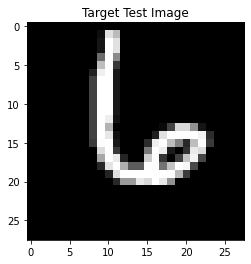

Model prediction: 6


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


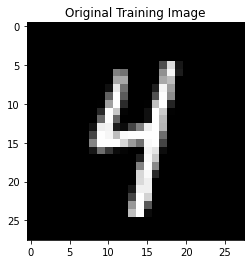

Model prediction: 4


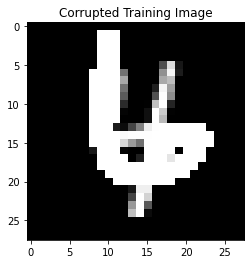

Model prediction: 6


In [14]:
def check_image(image_path, descriptor):
    image = Image.open(image_path)
    image = np.asarray(image)
        # plot the sample
    fig = plt.figure
    plt.title(descriptor)
    plt.imshow(image, cmap='gray')
    plt.show()
    return image

def compare_image_sets(original_model, src_image_dir, corrupt_image_dir):
    corrupt_image_list = [os.path.join(corrupt_image_dir, f) for f in os.listdir(corrupt_image_dir) if os.path.isfile(os.path.join(corrupt_image_dir, f))]
    
    corrupt_image = np.random.choice(corrupt_image_list,1)[0]

    original_image = os.path.join(src_image_dir, corrupt_image.split('_')[-1])
    
    target_image =  f"/nfs/1/datasets/Mnist/testing/{original_label}/{target_file}"
    
    image = check_image(target_image, "Target Test Image")
    print("Model prediction: " + str(np.argmax(original_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))
    image = check_image(original_image, "Original Training Image")
    print("Model prediction: " + str(np.argmax(original_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))
    image = check_image(corrupt_image, "Corrupted Training Image")
    print("Model prediction: " + str(np.argmax(original_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))

src  = f"/nfs/1/datasets/Mnist/training/{target_label}"
corr_src = f"./poisoned_images/adv_poison_data/{target_label}"
compare_image_sets(original_model,src, corr_src)
    

Now we will deploy the poisoned images into the original target dataset for training.

In [15]:
response_deploy_poison_le_net = restapi_client.submit_job(
    workflows_file=WORKFLOWS_TAR_GZ,
    experiment_name=EXPERIMENT_NAME,
    entry_point="deploy_poison",
    entry_point_kwargs=" ".join(
        [
            f"-P run_id={response_gen_poison_le_net['mlflowRunId']}",
            "-P data_dir=/nfs/data/Mnist/training",
            "-P poison_deployment_method=replace",
            #"-P num_poisoned_images=100",
        ]
    ),
    queue="tensorflow_cpu",
    depends_on=response_gen_poison_le_net["jobId"],
)


print("Poison deployment (LeNet-5 architecture) job submitted")
print("")
pprint.pprint(response_deploy_poison_le_net)
print("")

while mlflow_run_id_is_not_known(response_deploy_poison_le_net):
    time.sleep(1)
    response_deploy_poison_le_net = restapi_client.get_job_by_id(response_deploy_poison_le_net["jobId"])

Poison deployment (LeNet-5 architecture) job submitted

{'createdOn': '2020-12-10T08:56:37.816544',
 'dependsOn': 'ef02ff4a-6e9f-44f0-a33e-7779bb0bfc56',
 'entryPoint': 'deploy_poison',
 'entryPointKwargs': '-P run_id=22aa6177f1b2401589af89fb0d85aba2 -P '
                     'data_dir=/nfs/data/Mnist/training -P '
                     'poison_deployment_method=replace',
 'experimentId': 9,
 'jobId': '0dbb955a-27d5-4aeb-8d72-b1c7ee0d1f42',
 'lastModified': '2020-12-10T08:56:37.816544',
 'mlflowRunId': None,
 'queueId': 1,
 'status': 'queued',
 'timeout': '24h',
 'workflowUri': 's3://workflow/ab119579515e4704bc980c8954bb3822/workflows.tar.gz'}



### Finally, train and retest poisoned dataset.

In [16]:
response_le_net_poison_mnist_training = restapi_client.submit_job(
    workflows_file=WORKFLOWS_TAR_GZ,
    experiment_name=EXPERIMENT_NAME,
    entry_point="train",
    entry_point_kwargs=" ".join(
        [
            f"-P training_dataset_run_id={response_deploy_poison_le_net['mlflowRunId']}",
            "-P batch_size=256",
            "-P register_model=True",
            "-P model_architecture=le_net",
            f"-P model_tag=poisoned_runID_{response_deploy_poison_le_net['mlflowRunId']}",
            "-P epochs=30",
            "-P data_dir_train=/nfs/data/",
            "-P data_dir_test=/nfs/data/Mnist/testing",
            "-P load_dataset_from_mlruns=True",

        ]
    ),
    
    queue="tensorflow_gpu",
    depends_on=response_deploy_poison_le_net["jobId"],
)


print("Poisoned training (LeNet-5 architecture) job submitted")
print("")
pprint.pprint(response_le_net_poison_mnist_training)
print("")

# Wait for poisoned training to finish.
while (response_le_net_poison_mnist_training['status'] != 'finished'):
    time.sleep(1)
    response_le_net_poison_mnist_training = restapi_client.get_job_by_id(response_le_net_poison_mnist_training["jobId"])

Poisoned training (LeNet-5 architecture) job submitted

{'createdOn': '2020-12-10T08:56:41.930147',
 'dependsOn': '0dbb955a-27d5-4aeb-8d72-b1c7ee0d1f42',
 'entryPoint': 'train',
 'entryPointKwargs': '-P testing_dataset_run_id=None -P '
                     'training_dataset_run_id=ec960ca901514d6b940b98a36ee9ac31 '
                     '-P batch_size=256 -P register_model=True -P '
                     'model_architecture=le_net -P '
                     'model_tag=poisoned_runID_ec960ca901514d6b940b98a36ee9ac31 '
                     '-P epochs=30 -P data_dir_train=/nfs/data/ -P '
                     'data_dir_test=/nfs/data/Mnist/testing -P '
                     'load_dataset_from_mlruns=True',
 'experimentId': 9,
 'jobId': '1c35982c-45da-46cc-8c7e-3bbffe54f611',
 'lastModified': '2020-12-10T08:56:41.930147',
 'mlflowRunId': None,
 'queueId': 2,
 'status': 'queued',
 'timeout': '24h',
 'workflowUri': 's3://workflow/6cb5fe21c9df45d1b7cc3b6bb6f052b7/workflows.tar.gz'}



### Let's check if the attack worked, the target image should be reclassified as beloning to the new target class.

In [17]:
corrupt_model = load_model_from_job_run(response_le_net_poison_mnist_training['mlflowRunId'], './test_dir')

Accessing MLflow Client Server. Downloading model files.
{'Server': 'nginx/1.18.0 (Ubuntu)', 'Date': 'Thu, 10 Dec 2020 09:00:22 GMT', 'Content-Type': 'application/octet-stream', 'Content-Length': '14446376', 'Connection': 'keep-alive', 'Content-Disposition': 'attachment; filename=model.h5', 'Last-Modified': 'Thu, 10 Dec 2020 09:00:22 GMT', 'Cache-Control': 'public, max-age=43200', 'Expires': 'Thu, 10 Dec 2020 21:00:22 GMT', 'ETag': '"1607590822.5492136-14446376-4137225496"'}


/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hhuang/.conda/envs/tensorflow-mnist-classifier/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Original Image label: 6
Predicted label (original model): 6
Predicted label (corrupted model): 6


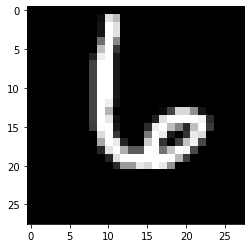

In [18]:
target_image = f"/nfs/1/datasets/Mnist/testing/{original_label}/{target_file}"

# load and show an image with Pillow
from PIL import Image
import tensorflow as tf
# Open the image form working directory
image = Image.open(target_image)
# summarize some details about the image
print("Original Image label: " + str(original_label) )
print("Predicted label (original model): " + str(np.argmax(original_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))
print("Predicted label (corrupted model): " + str(np.argmax(corrupt_model.predict(np.reshape(image, (1,28,28,1))), axis=1)[0]))
image = np.asarray(image)

# display the array of pixels as an image
import matplotlib.pyplot as plt
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()